In [12]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

In [13]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)

In [14]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

## Test data correctness

In [15]:
test_df = pd.DataFrame({'Close_yesterday': data['SPY'].shift(1),'Close Tody':data['SPY'],'Target': binary_targets['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450684,0
2012-01-04,100.450684,100.608261,1
2012-01-05,100.608261,100.876129,1
2012-01-06,100.876129,100.616127,0
2012-01-09,100.616127,100.860359,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


In [16]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
                
        y_target = target_label.iloc[i+window_size]
        y.append(y_target)
        
        
    X = np.array(X)
    y = np.array(y)

    return X, y

window_size = 30
X, y = create_X_y_rolling(data, binary_targets, window_size)
X.shape, y.shape


((3378, 30, 33), (3378, 33))

In [17]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [18]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False),
    Dropout(0.2),  

    Dense(y_train.shape[1], activation='sigmoid'),
])



model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.01),   
              metrics=['binary_accuracy',])

cp = ModelCheckpoint(filepath='model_binary/best_binary.keras', 
                     save_best_only=True, monitor='val_loss', 
                     mode='min')

es = EarlyStopping(
    monitor='val_loss',        
    patience=10,                
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()




c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - binary_accuracy: 0.5524 - loss: 0.6686 - val_binary_accuracy: 0.4990 - val_loss: 0.7291
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - binary_accuracy: 0.5598 - loss: 0.6608 - val_binary_accuracy: 0.5152 - val_loss: 0.7396
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - binary_accuracy: 0.5548 - loss: 0.6614 - val_binary_accuracy: 0.4981 - val_loss: 0.7387
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - binary_accuracy: 0.5532 - loss: 0.6608 - val_binary_accuracy: 0.5067 - val_loss: 0.7269
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - binary_accuracy: 0.5559 - loss: 0.6601 - val_binary_accuracy: 0.5052 - val_loss: 0.7353
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.5563 - loss: 0.6587 - val_binary_accuracy: 0.5017 - val_loss: 0.7331
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - binary_accuracy: 0.5567 - loss: 0.6602 - val_binary_accuracy: 0.5065 - val_loss: 0.7311
Epoch

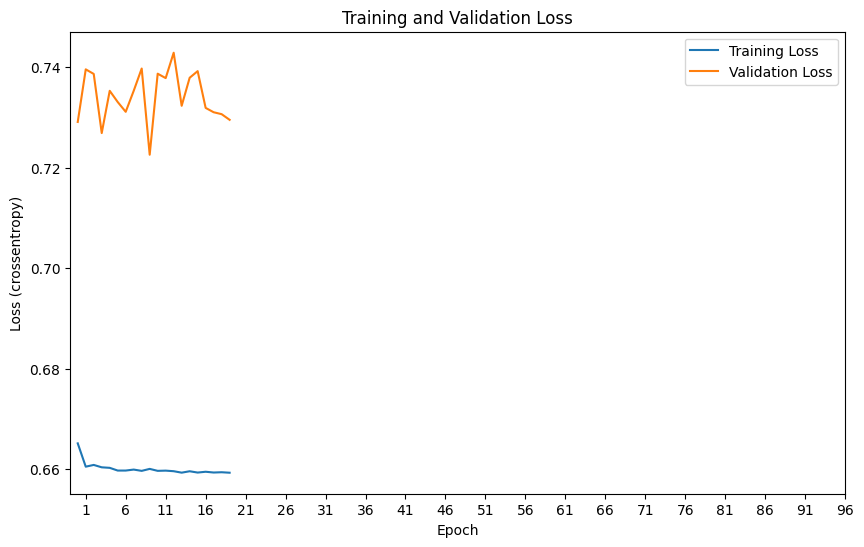

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (crossentropy)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [20]:

from sklearn.metrics import f1_score, precision_score, recall_score

# Flatten predictions and ground truth
y_val_pred = model.predict(X_val)
# print(y_val_pred)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

print("F1:", f1_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Precision:", precision_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Recall:", recall_score(y_val.flatten(), y_val_pred_binary.flatten()))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
F1: 0.43029682702149435
Precision: 0.47513562386980107
Recall: 0.39319117096894873


In [21]:
model = load_model('model_binary/best_binary.keras')
index_series = data.index[-len(y_test):]

y_pred = model.predict(X_test)
display(y_pred)

y_pred_classes = (y_pred > 0.6).astype(int)

Predict_result_df = pd.DataFrame(y_pred_classes, index=index_series, columns=data.columns)


display(Predict_result_df)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


array([[0.28437978, 0.41518214, 0.21606489, ..., 0.520861  , 0.49627298,
        0.4809093 ],
       [0.28436506, 0.4151828 , 0.21604665, ..., 0.5208689 , 0.49626276,
        0.48091468],
       [0.28442094, 0.41519266, 0.21611758, ..., 0.5208492 , 0.4962763 ,
        0.48091012],
       ...,
       [0.2846542 , 0.41525298, 0.21637331, ..., 0.5207777 , 0.49637687,
        0.48085392],
       [0.28473046, 0.415272  , 0.21646121, ..., 0.52075434, 0.4964006 ,
        0.4808417 ],
       [0.28474358, 0.41528308, 0.2164779 , ..., 0.5207537 , 0.49639437,
        0.4808411 ]], dtype=float32)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
y_test

array([[1, 1, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [25]:
from sklearn.metrics import accuracy_score

actual_flat = y_test.flatten()
predicted_flat = Predict_result_df.to_numpy().flatten()

accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.4861


In [27]:
average = Predict_result_df
display(average)
num_ones = (average == 1).sum()
num_zeros = (average == 0).sum()
y_pred_mean = (num_ones > num_zeros).astype(int)
y_pred_mean_df = pd.DataFrame(y_pred_mean, index = Predict_result_df.columns, columns=['Predicted Trend'])
display(y_pred_mean_df.T)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Predicted Trend,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
yesterday_prices = data.iloc[-2] 
today_prices_actual = data.iloc[-1] 
y_actual = binary_targets.iloc[-1] 
today_taget_predicted = pd.Series(y_pred_mean, index=Predict_result_df.columns)

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_actual_target': y_actual,
    'Today_pred_target': y_pred_mean,
})


tickers_names = binary_targets.columns

correct_list = []
for ticker in tickers_names:
    predict = today_taget_predicted[ticker]
    actual = y_actual[ticker]
    if predict == actual:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today actual target'] = comparison_df['Today_actual_target'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred_target'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_binary_6.csv', index=False)

Count of correct predictions: 30
accuracy: 0.9090909090909091


,Yesterday actual,Today actual,Today actual target,Today pred target,Correct
AIEQ,37.66,36.85,0,0,1
ASHR.L,10.46,10.34,0,0,1
BCHN.L,97.08,92.71,0,0,1
CORN,18.51,18.46,0,0,1
DBO,14.13,13.97,0,0,1
EDEN,105.33,105.17,0,0,1
EMXC,56.11,55.18,0,0,1
EWA,23.75,23.47,0,0,1
EWC,41.25,40.57,0,0,1
EWG,37.59,37.39,0,0,1
